## Visualização e pré-processamento

A seguir, a implementação de cada um dos filtros: passa-faixa (bandpass), passa-baixa (lowpass), passa-alta (highpass) e corta-faixa (notch).

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne


# definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=512, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

Para imprimir os dados no domínio da frequência, foi utilizado a função `matplotlib.pyplot.psd` que na verdade utiliza a transformação dos dados por FFT, porém aplica uma característica que evidencia a "energia" dos dados, chamado de PSD (_Power Spectrum Density_)

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [9]:
def print_graphs(data):
    for i in range(0, 21, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 21, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 21, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

Carregamento dos dados de um participante da base de dados AVI:

In [10]:
data = np.load("../datasets/avi/single/data_sub1.npy")
print(data.shape)

# Transpondo dados para organizar os dados na última dimensão
data = data.T
data.shape

(4, 15360, 21)


(21, 15360, 4)

Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

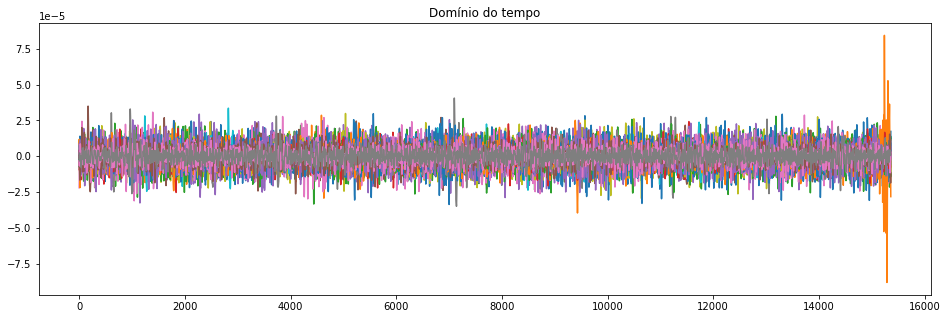

ValueError: only 1-dimensional arrays can be used

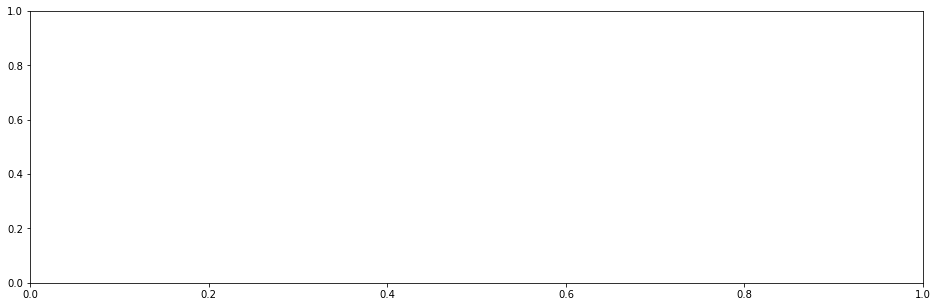

In [11]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data)

Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta `MNE`:

In [ ]:
# criação de um objeto "info"
n_channels = 1
sfreq = 512
ch_names = ['Oz']
ch_types = ['eeg']
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: Oz
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 512.0 Hz
>

In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = np.load("datasets/avi/single/labels_sub1.npy")[0]
print(labels, labels.shape)

[10.  10.  10.   6.5  6.5  6.5  6.   6.   6.   7.5  7.5  7.5  7.   7.
  7.   8.2  8.2  8.2  9.3  9.3  9.3] (21,)


In [ ]:
# data : array, shape (n_epochs, n_channels, n_times)
data_correct = data.reshape(data.shape[0], 1, data.shape[1])
# adicionando label como "épocas" do sinal
labels = np.load("datasets/avi/single/labels_sub1.npy")[0]
# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(21, dtype=int),
    le.fit_transform(labels))
)
event_dict = {'6':0, '6.5':1, '7':2, '7.5':3, '8.2':4, '9.3':5, '10':6}
mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
mne_data

Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated


Number of events,21
Events,10: 36: 36.5: 37: 37.5: 38.2: 39.3: 3
Time range,0.000 – 29.998 s
Baseline,off


    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for eeg. Disabling interactivity.
21


/tmp/ipykernel_41306/2813220505.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  view.plot()
/home/rhubner/sandbox/tutoriais/venv/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


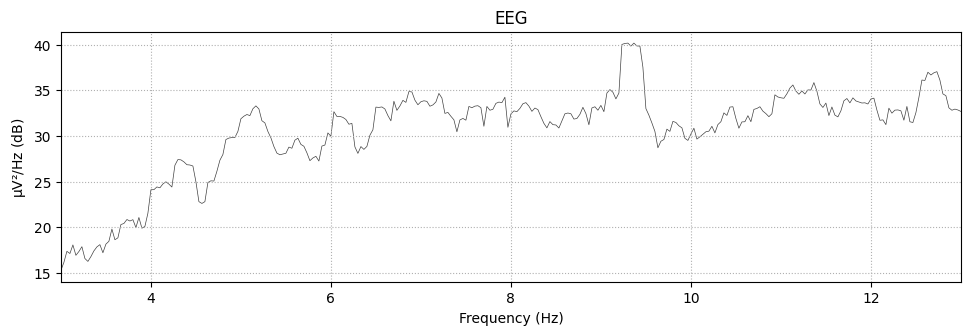

In [ ]:


# view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
view = mne_data[20].compute_psd(method='multitaper', fmin=3, fmax=13)
print(len(mne_data))
view.plot()
print()
